# Exercise 5: Deep Q-Network (DQN)

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import scipy.misc
import tensorflow as tf

from unityagents import UnityEnvironment

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Hyperparameters

In [2]:
batch_size = 64 # How many experiences to use for each training step.
update_freq = 8 # How often to perform a training step.
y = 0.8 # Discount factor on the target Q-values
startE = 1 # Starting chance of random action
endE = 0.1 # Final chance of random action
anneling_steps = 100000 # How many steps of training to reduce startE to endE.
num_episodes = 5000 # How many episodes of game environment to train network with.
pre_train_steps = 5000 # How many steps of random actions before training begins.
model_path = "./models/dqn-12" # The path to save our model to.
summary_path = './summaries/dqn-12' # The path to save summary statistics to.
h_size = 128 # The number of units in the hidden layer.
learning_rate = 3e-4 # Agent Learning Rate
load_model = False # Whether to load a saved model.
train_model = True # Whether to train the model

### Load the Unity environment

In [3]:
env = UnityEnvironment(file_name="./envs/GridWorld", worker_id=4)
default_brain = env.brain_names[0]

INFO:unityagents:
'GridAcademy' started successfully!
Unity Academy name: GridAcademy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		gridSize -> 5.0
		numObstacles -> 1.0
		numGoals -> 1.0
Unity brain name: GridWorldBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Examine observation space

Agent state looks like: 
[]
Agent observations look like:


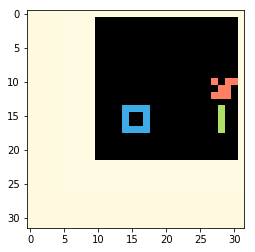

In [4]:
# Reset the environment
env_info = env.reset()[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
for observation in env_info.visual_observations:
    print("Agent observations look like:")
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

[-0.009999999776482582] [False]
Agent observations look like:


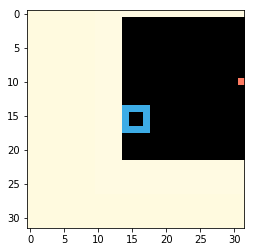

In [5]:
brain = env.step(2)[default_brain]
print(brain.rewards, brain.local_done)
for observation in brain.visual_observations:
    print("Agent observations look like:")
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

Observation (o) corresponds to a pixel image of the screen.

### Implementing the network itself

In [6]:
class Qnetwork():
    def __init__(self ,h_size, num_actions, lr, scope):
        with tf.variable_scope(scope):
            # The network recieves a frame from the game, flattened into an array.
            # It then resizes it and processes it through four convolutional layers.
            self.observation_input =  tf.placeholder(shape=[None, 32, 32, 3],dtype=tf.float32)
            self.conv1 = tf.layers.conv2d(self.observation_input, 16, 
                                     kernel_size=[3, 3], strides=[2, 2], 
                                     use_bias=False,
                                     activation=tf.nn.elu)
            self.conv2 = tf.layers.conv2d(self.conv1, 32, 
                                     use_bias=False,
                                     kernel_size=[3, 3], 
                                     strides=[2, 2], 
                                     activation=tf.nn.elu)

            # We take the output from the final convolutional layer 
            # and split it into separate advantage and value streams.
            self.hidden = tf.layers.dense(tf.layers.flatten(self.conv2), 
                                               h_size, activation=tf.nn.elu)
            self.Q_estimate = tf.layers.dense(self.hidden, num_actions, activation=None,
                                                  use_bias=False)

            self.predict = tf.argmax(self.Q_estimate, 1)
            self.value = tf.reduce_mean(self.Q_estimate, axis=1)

            # Below we obtain the loss by taking the sum of squares difference 
            # between the target and prediction Q values.
            self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, num_actions, dtype=tf.float32)

            self.Q = tf.reduce_sum(tf.multiply(self.Q_estimate, self.actions_onehot), axis=1)

            self.td_error = tf.squared_difference(self.targetQ, self.Q)
            self.loss = tf.reduce_mean(self.td_error)
            self.trainer = tf.train.AdamOptimizer(learning_rate=lr)
            self.update = self.trainer.minimize(self.loss)

### Experience Replay

This class allows us to store experies and sample then randomly to train the network.

In [7]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

These functions allow us to update the parameters of our target network with those of the primary network.

In [8]:
def update_target_graph(from_scope, to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

### Training the network

In [9]:
tf.reset_default_graph()
action_size = env.brains[default_brain].vector_action_space_size

mainQN = Qnetwork(h_size, action_size, learning_rate, "main")
targetQN = Qnetwork(h_size, action_size, learning_rate, "target")

init = tf.global_variables_initializer()

if not os.path.exists(summary_path):
    os.makedirs(summary_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver = tf.train.Saver()

trainables = tf.trainable_variables()

update_target_ops = update_target_graph("main", "target")

myBuffer = experience_buffer()

# Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

# Create lists to contain total rewards and steps per episode
episode_lengths = []
episode_rewards = []
losses = []
episode_values = []
total_steps = 0

with tf.Session() as sess:
    brains = env.reset()
    observation = brains[default_brain].visual_observations[0][0]
    sess.run(init)
    summary_writer = tf.summary.FileWriter(summary_path)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        done = False
        episode_reward = 0
        episode_steps = 0
        values = []
        while not done:
            episode_steps+=1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            action, value = sess.run([mainQN.predict, mainQN.value], 
                  feed_dict={mainQN.observation_input:[observation]})

            if (np.random.rand(1) < e or total_steps < pre_train_steps) and train_model:
                action = np.random.randint(0, action_size)                
            brains = env.step(action)
            grid_brain = brains[default_brain]
            observation_1 = grid_brain.visual_observations[0][0]
            reward = grid_brain.rewards[0]
            done = grid_brain.local_done[0]            
            total_steps += 1
            
            # Save the experience to our episode buffer.
            episodeBuffer.add(np.reshape(np.array([observation,action,reward,observation_1,done]),[1,5])) 
            
            # Training-specific logic below
            if total_steps > pre_train_steps and train_model:
                if total_steps % 3000 == 0:
                    sess.run(update_target_ops)
                
                if e > endE:
                    e -= stepDrop
                
                if total_steps % update_freq == 0:
                    # Get a random batch of experiences.
                    trainBatch = myBuffer.sample(batch_size) 
                    
                    # Below we perform the Double-DQN update to the target Q-values
                    # See here for DDQN reference: https://arxiv.org/abs/1509.06461
                    Q1 = sess.run(mainQN.predict, 
                                  feed_dict={mainQN.observation_input:np.stack(trainBatch[:,3], axis=0)})
                    
                    Q2 = sess.run(targetQN.Q_estimate, 
                                  feed_dict={targetQN.observation_input:np.stack(trainBatch[:,3], axis=0)})

                    end_multiplier = 1.0 * np.invert(trainBatch[:,4])
                    doubleQ = Q2[range(batch_size), Q1]
                    targetQ = trainBatch[:,2] + (y * doubleQ * end_multiplier)
                    
                    # Update the network with our target values.
                    _, q_loss = sess.run([mainQN.update, mainQN.loss],
                        feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})
                    losses.append(q_loss)
            
            episode_reward += reward
            observation = observation_1
            values.append(value)
                    
        myBuffer.add(episodeBuffer.buffer)
        episode_lengths.append(episode_steps)
        episode_rewards.append(episode_reward)
        episode_values.append(np.mean(values))
        
        # Periodically save the model and summary statistics
        if i % 1000 == 0 and i != 0:
            saver.save(sess, model_path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if i % 50 == 0 and i != 0:
            summary = tf.Summary()
            summary.value.add(tag='Info/Reward', simple_value=float(np.mean(episode_rewards[-50:])))
            summary.value.add(tag='Info/Q Loss', simple_value=float(np.mean(losses[-100:])))
            summary.value.add(tag='Info/Q Estimate', simple_value=float(np.mean(episode_values[-50:])))
            summary.value.add(tag='Info/Epsilon', simple_value=float(e))
            summary.value.add(tag='Info/Episode Length', simple_value=float(np.mean(episode_lengths[-50:])))
            summary_writer.add_summary(summary, i)
            summary_writer.flush()
            print("Step: {}, Episode: {}, Epsilon: {}, Mean Reward: {}".format(str(total_steps), 
                                                                               str(i), str(round(e, 2)), 
                                                                               str(round(np.mean(episode_rewards[-50:]), 3))))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step: 1210, Episode: 50, Epsilon: 1, Mean Reward: -0.245
Step: 2720, Episode: 100, Epsilon: 1, Mean Reward: -0.252
Step: 4025, Episode: 150, Epsilon: 1, Mean Reward: -0.371
Step: 5021, Episode: 200, Epsilon: 1.0, Mean Reward: 0.051
Step: 6129, Episode: 250, Epsilon: 0.99, Mean Reward: -0.312
Step: 7238, Episode: 300, Epsilon: 0.98, Mean Reward: -0.052
Step: 8581, Episode: 350, Epsilon: 0.97, Mean Reward: -0.339
Step: 9969, Episode: 400, Epsilon: 0.96, Mean Reward: -0.428
Step: 11525, Episode: 450, Epsilon: 0.94, Mean Reward: -0.302
Step: 12805, Episode: 500, Epsilon: 0.93, Mean Reward: -0.187
Step: 14192, Episode: 550, Epsilon: 0.92, Mean Reward: -0.288
Step: 15796, Episode: 600, Epsilon: 0.9, Mean Reward: -0.291
Step: 17026, Episode: 650, Epsilon: 0.89, Mean Reward: -0.316
Step: 18026, Episode: 700, Epsilon: 0.88, Mean Reward: -0.01
Step: 19256, Episode: 750, Epsilon: 0.87, Mean Reward: 0.004
Step: 20801, Episode: 800, Epsilon: 0.86, Mean Reward: -0.28
Step: 22102, Episode: 850, Epsil

KeyboardInterrupt: 

In [ ]:
env.close()